## TELCO CUSTOMER CHURN

## Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading the dataset

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

100%|██████████| 172k/172k [00:00<00:00, 201kB/s]

Extracting files...
Path to dataset files: C:\Users\KIRAN\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [9]:
df = pd.read_csv(os.path.join(path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

## Information of the dataset

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df.shape

(7043, 21)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## EDA Analysis

### Handling the missing values

In [13]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()  # Drops 11 rows with blank TotalCharges




In [20]:
# Encode target
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df['Churn'] = le_target.fit_transform(df['Churn'])  # No=0, Yes=1



In [21]:
# Encode categorical features (drop customerID)
cat_cols = df.select_dtypes('object').columns.drop('customerID')
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print('Preprocessed shape:', df.shape)
print('Churn after encoding:\n', df['Churn'].value_counts(normalize=True))

Preprocessed shape: (7032, 21)
Churn after encoding:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


## Prepare Features & Split

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (5625, 19)
Test shape: (1407, 19)


## train model

In [23]:
# Scale features (important for LogisticRegression)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_logreg = logreg_model.predict(X_test_scaled)
y_pred_proba_logreg = logreg_model.predict_proba(X_test_scaled)[:, 1]

print('Logistic Regression trained successfully')
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_proba_logreg))

Logistic Regression trained successfully
Accuracy: 0.7938877043354655
AUC-ROC: 0.8345028498066479


In [25]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[906 127]
 [163 211]]


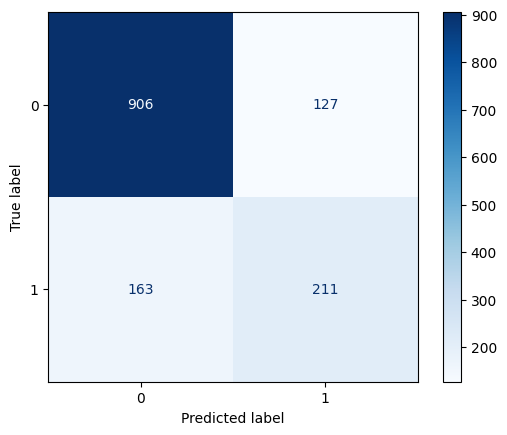

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
disp.plot(cmap=plt.cm.Blues)